In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

## 1. Recursive Filter Method

## 1.1 Convolution Integral Method

$\ddot{x}_n = b_0 \cdot \ddot{y}_n + b_1 \cdot \ddot{y}_{n-1} + b_2 \cdot \ddot{y}_{n-2} - a_1 \cdot \ddot{x}_{n-1} - a_2 \cdot \ddot{x}_{n-2}$

$b_0=2\zeta\omega_n\Delta t$

$b_1=\omega_n\Delta t exp[-\zeta\omega_n\Delta t]\left\{ \left[ \frac{\omega_n}{\omega_d}(1-2\zeta^2) \right]sin[\omega_d \Delta t]-2\zeta cos[\omega_d \Delta t] \right\}$

$b_2 = 0$

$a_1 = -2exp[-\zeta\omega_n\Delta t]cos[\omega_d\Delta t]$

$a_2 = exp[-2\zeta\omega_n\Delta t]$

In [8]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_conv(th_in,dt,fn,zeta): # Kelly-Richman

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 2*zeta*wn*dt;
    b[1] = wn*dt*np.exp(-zeta*wn*dt)*((wn/wd)*(1-2*zeta**2)*np.sin(wd*dt)-2*zeta*np.cos(wd*dt));
    b[2] = 0;

    a[0] = 1
    a[1] = -2*np.exp(-zeta*wn*dt)*np.cos(wd*dt);
    a[2] = np.exp(-2*zeta*wn*dt);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

## 1.2 Ramp Invariant Method (ISO 18431-4)

Shock Response Spectra 계산 Coefficient

$\ddot{x}_n = b_0 \cdot \ddot{y}_n + b_1 \cdot \ddot{y}_{n-1} + b_2 \cdot \ddot{y}_{n-2} - a_1 \cdot \ddot{x}_{n-1} - a_2 \cdot \ddot{x}_{n-2}$

$b_0 = 1- exp(-A)\cdot sin(B)/B$

$b_1 = 2exp(-A)\cdot {sin(B)/B - cos(B)}$

$b_2 = exp(-2A)-exp(-A)\cdot sin(B)/B$

$a_1 = -2exp(-A)\cdot cos(B)$

$a_2 = exp(-2A)$

$A = \frac{\omega_n \cdot T}{2Q}$

$B = \omega_n \cdot T \cdot \sqrt{1-\frac{1}{4Q^2}}$

In [3]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta): 

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [4]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ramp_invariant(th_in,dt,fn,zeta): # Smallwood
    
    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    E = np.exp(-zeta*wn*dt);
    K = dt*wd;
    C = E*np.cos(K);
    S = E*np.sin(K);
    Sp = S/K;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - Sp;
    b[1] = 2*(Sp-C);
    b[2] = E**2 - Sp;

    a[0] = 1;
    a[1] = -2*C;
    a[2] = E**2;

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;        

## Newmark $\beta$ Method

In [5]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_newmark(th_in,dt,fn,zeta):
    def newmark_parameter(dt):
        r = 0.005; alpha = (1/4)*((1+r)**2); delta = 0.5 + r;
        a = np.zeros(8);
        a[0] = 1/(alpha*dt*dt); a[1] = delta/(alpha*dt); a[2] = 1/(alpha*dt); a[3] = 1/(2*alpha)-1;
        a[4] = delta/alpha - 1; a[5] = (dt/2)*((delta/alpha)-2); a[6] = dt*(1-delta); a[7] = delta*dt;
        return a;
    def DERIV(X,Y):
        N = len(Y); YY = np.zeros(N);
        YY[0] = (Y[1]-Y[0])/(X[1]-X[0]); Y[N-1] = (Y[N-1]-Y[N-2])/(X[N-1]-X[N-2]);
        for n in range(N-2):
            YY[n+1] = (((Y[n+2]-Y[n+1])/(X[n+2]-X[n+1]))*(X[n+1]-X[n]) + ((Y[n+1]-Y[n])/(X[n+1]-X[n]))*(X[n+2]-X[n+1]))/(X[n+2]-X[n]);
        return YY;
    def INTEG(X,Y,C1):
        N = len(Y); YY = np.zeros(N);
        YY[0] = C1;
        for n in range(1,N):
            YY[n] = YY[n-1] + (1/2)*(Y[n]+Y[n-1])*(X[n]-X[n-1]);
        return YY;      
    a = newmark_parameter(dt);
    u,v,ac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    ru,rv,rac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    N = len(th_in);
    time = np.arange(N)*dt;
    vth = INTEG(time,th_in,0); dth = INTEG(time,vth,0);
    F = -th_in;
    wn = 2*np.pi*fn; m = 1; c = 2*zeta*wn; k = wn**2;            
    Fe = a[0]*m + a[1]*c + k;          
    for n in range(len(th_in)-1):
        ru[n+1] = (F[n+1] + m*(a[0]*ru[n]+a[2]*rv[n]+a[3]*rac[n])+c*(a[1]*ru[n]+a[4]*rv[n]+a[5]*rac[n]))/Fe;
        rv[n+1] = a[1]*(ru[n+1]-ru[n]) - a[4]*rv[n] - a[5]*rac[n];
        rac[n+1] = a[0]*(ru[n+1]-ru[n]) -a[2]*rv[n] - a[3]*rac[n];
    th_out= rac + th_in;
    return th_out

In [6]:
## Sample Time History 1
lftab = np.linspace(0,1000,1001)/10;  dt = 1/(20*max(lftab));  damp = 0.01;
t = np.arange(10001)*dt;
gth = 10*np.sin(2*np.pi*t) + 13*np.sin(2*np.pi*3*t+np.pi/1.3) + 17*np.sin(2*np.pi*5*t+np.pi/1.7);

In [27]:
## Sample Time History 2 (Random)
gth = np.random.uniform(-1,1,10001);

In [28]:
th_ISO = SDOF_ISO(gth,dt,10,0.02);
th_ri = SDOF_ramp_invariant(gth,dt,10,0.02);
th_conv = SDOF_conv(gth,dt,10,0.02);

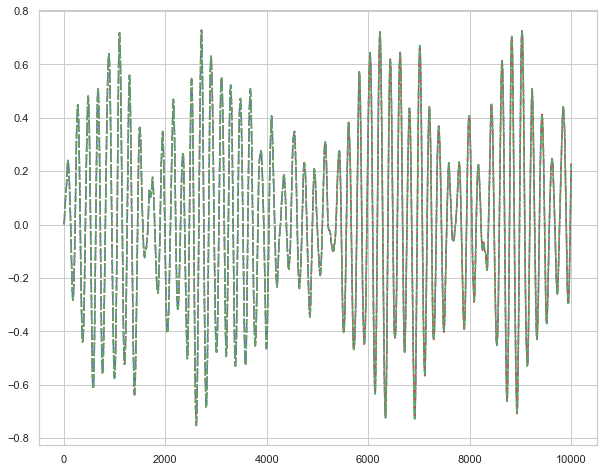

In [29]:
plt.figure(figsize=(10,8));
plt.plot(th_ISO,'b-.'); 
plt.plot(th_ri,'r--'); 
plt.plot(th_conv,'g--');

### 결론

Smallwood 논문과 ISO 18431-4의 응답스펙트럼계상방법 동일

Newmark 방법도 별 차이 없음